<a href="https://colab.research.google.com/github/Bharat-Moorthy/MLAI---Paathsalaassignments/blob/main/Sentimental_analysis_Twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#We are inputting the data and giving column names as dataset doesnt have any and also encoding them 

In [4]:
COLUMNS_NAMES  = ["sentiment", "ids", "date", "flag", "user", "text"]
ENCODING = "ISO-8859-1"
data = pd.read_csv('/content/drive/MyDrive/MLAI project/training.1600000.processed.noemoticon.csv',
                      encoding=ENCODING , names=COLUMNS_NAMES)
data.head()

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
#Getting the basic information about the dataset

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   ids        1600000 non-null  int64 
 2   date       1600000 non-null  object
 3   flag       1600000 non-null  object
 4   user       1600000 non-null  object
 5   text       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [7]:
#We have no null values in the dataset. So there is no missing values issue .
#There are only Int and object datatyes found in dataset

In [8]:
data.shape

(1600000, 6)

In [9]:
#The dataset shape is 16,00,000 rows and 6 columns

In [10]:
#For our problem statement we only need two columns sentiment(polarity) and text(tweet) , so we can drop all other columns

In [11]:
data = data[['sentiment','text']]
data['sentiment'] = data['sentiment'].replace(4,1)

<ipython-input-11-d595d34172c2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sentiment'] = data['sentiment'].replace(4,1)


In [12]:
# So the shape of the dataset will become (1600000, 2)

In [13]:
data["sentiment"].value_counts()

0    800000
1    800000
Name: sentiment, dtype: int64

In [14]:
#Here we can see that there is no neutral value as mentioned in the Dataset description and 
#only positive and negative sentiment is present in the dataset
#So this becomes a binary classification problem and the dataset is perfectly balanced one 

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


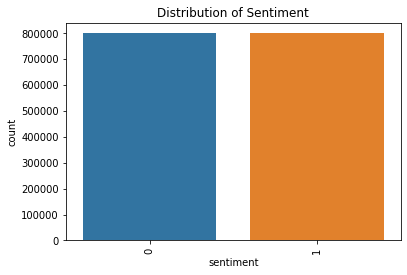

In [15]:
sns.countplot(data["sentiment"])
plt.title("Distribution of Sentiment")
plt.xticks(rotation=90)
plt.show()

In [16]:
#As seen before , this is a balanaced dataset

In [17]:
#Now we need to do the preprocessing 

In [18]:
#Preprocessing , the plan is as below:
#Lower Casing: Each text is converted to lowercase.
#Replacing Contractions: Replacing contractions with their meanings
#Replacing Emojis: Replace emojis by using a emoji name.
#Replacing Usernames: Replace @Usernames with ''
#Replacing URLs: Links starting with 'http' or 'https' or 'www' are replaced by ''.
#Replacing Consecutive letters: 3 or more consecutive letters are replaced by 2 letters
#Removing Non-Alphabets: Replacing characters except Digits, Alphabets and pre-defined Symbols with a "".
#Removing the punctuation 

In [19]:
#1.Change to Lowercase

In [20]:
data['text']=data['text'].str.lower()
data

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - awww, t..."
1,0,is upset that he can't update his facebook by ...
2,0,@kenichan i dived many times for the ball. man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,1,just woke up. having no school is the best fee...
1599996,1,thewdb.com - very cool to hear old walt interv...
1599997,1,are you ready for your mojo makeover? ask me f...
1599998,1,happy 38th birthday to my boo of alll time!!! ...


In [21]:
#2.Replacing abbrevated words with full words

In [22]:
contractions = pd.read_csv('/content/drive/MyDrive/MLAI project/contractions.csv', index_col='Contraction')
contractions.index = contractions.index.str.lower()
contractions.Meaning = contractions.Meaning.str.lower()
contractions_dict = contractions.to_dict()['Meaning']


def correct_words(text):
  for contraction, replacement in contractions_dict.items():
    text = text.replace(contraction," " + replacement)
    
  return text

data["text"]=data["text"].apply(correct_words)

In [23]:
data["text"][0]

'@switchfoot http://twitpic.com/2y1zl - awww, that is a bummer.  you shoulda got david carr of third day to do it. ;d'

In [24]:
#3.Change emoji symbols with emoji names

In [25]:
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-e': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':p': 'raspberry', ':o': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':x': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-d': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'o:-)': 'angel','o*-)': 'angel','(:-d': 'gossip', '=^.^=': 'cat','<3':"Heart",';d':'Laugh'}

def correct_emoji(text):
  for emoji in emojis.keys():
    text = text.replace(emoji, "EMOJI" + emojis[emoji])

  return text

data["text"]=data["text"].apply(correct_emoji)

In [26]:
data["text"][0]

'@switchfoot http://twitpic.com/2y1zl - awww, that is a bummer.  you shoulda got david carr of third day to do it. EMOJILaugh'

In [27]:
#4.Change username to " "

In [28]:
import re
def correct_username(text):
    return re.sub(r'@[A-Za-z0-9]+',' ', text)
data['text'] = data['text'].apply(lambda x: correct_username(x))

In [29]:
data["text"][0]

'  http://twitpic.com/2y1zl - awww, that is a bummer.  you shoulda got david carr of third day to do it. EMOJILaugh'

In [30]:
#5.Change URL pattern to ""

In [31]:
urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
def correct_url(text):
  return re.sub(urlPattern,' ',text)

data['text'] = data['text'].apply(lambda x: correct_url(x))

In [32]:
data["text"][0]

'    - awww, that is a bummer.  you shoulda got david carr of third day to do it. EMOJILaugh'

In [33]:
#6.Cleaning Repeative character

In [ ]:
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"
def clean_repeating_char(text):
    return re.sub(sequencePattern, seqReplacePattern, text)
    
data['text'] = data['text'].apply(lambda x: clean_repeating_char(x))


In [34]:
data["text"][0]

'    - awww, that is a bummer.  you shoulda got david carr of third day to do it. EMOJILaugh'

In [35]:
#7.Cleaning Punctuation

In [36]:
import string
punctuation_list=string.punctuation
def clean_punctuations(text):
    translator=str.maketrans('', '', punctuation_list)
    return text.translate(translator)
data['text']= data['text'].apply(lambda x: clean_punctuations(x))


In [37]:
data["text"][0]

'     awww that is a bummer  you shoulda got david carr of third day to do it EMOJILaugh'

In [38]:
# 8. Remove Numbers

In [39]:
def clean_numbers(data):
    return re.sub('[0-9]+', '', data)
data['text'] = data['text'].apply(lambda x: clean_numbers(x))


In [40]:
data["text"][0]

'     awww that is a bummer  you shoulda got david carr of third day to do it EMOJILaugh'

In [41]:
#After the initial preprocessing we do the next level preprocessing 
#Stop words removal 
#Lemmatisation 
#Tokenisation
#Removing two letter words

In [42]:
nltk.download('stopwords')
stopword = stopwords.words('english')
stopword.remove("not")
print(stopword)


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [43]:
def clean_text(text):
  token=word_tokenize(text)
  final_tokens = [w for w in token if w not in stopword]
  wordLemmate = WordNetLemmatizer()
  finaltext=[]
  for w in final_tokens:
    if len(w)>2:
      word = wordLemmate.lemmatize(w)
      finaltext.append(word)
  return ' '.join(finaltext)



In [44]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [45]:
#data['text']= data['text'].apply(lambda x: clean_text(x))

In [46]:
data

,sentiment,text
0,0,awww that is a bummer you shoulda got da...
1,0,is upset that he cannot update his facebook b...
2,0,i dived many times for the ball managed to s...
3,0,my whole body feels itchy and like its on fire
4,0,no it is not behaving at all i am mad why ...
...,...,...
1599995,1,just woke up having no school is the best feel...
1599996,1,thewdbcom very cool to hear old walt intervie...
1599997,1,are you ready for your mojo makeover ask me fo...
1599998,1,happy th birthday to my boo of alll time tupac...


In [47]:
#Word-Cloud-produces an image with frequently-appearing words in the text document, 
#where the most frequent words are showcased with bigger font sizes, and less frequent words with smaller font sizes.

In [48]:
#Word-Cloud for negative tweet

In [49]:
#from wordcloud import WordCloud
#from PIL import Image
#mask=np.array(Image.open("/content/drive/MyDrive/MLAI project/Black_Circle.jpg"))
#plt.figure(figsize = (15,15)) 
#wc = WordCloud(max_words=200,width = 5000 , height = 5000,background_color="white",colormap="magma").generate(" ".join(data[data.sentiment == 0].text))
#plt.imshow(wc , interpolation = 'bilinear')

In [50]:
#Based on the wordcloud , we can infer that most repeated words with negative sentiment are 
#work,today,one,amp,sad,miss,sorry etc

In [51]:
#from wordcloud import WordCloud
#from PIL import Image
#mask=np.array(Image.open("/content/drive/MyDrive/MLAI project/Black_Circle.jpg"))
#plt.figure(figsize = (15,15)) 
#wc = WordCloud(max_words = 200 , width = 5000 , height = 5000,background_color="white",colormap="magma").generate(" ".join(data[data.sentiment == 4].text))
#plt.imshow(wc , interpolation = 'bilinear')

In [52]:
#Based on the wordcloud , we can infer that most repeated words with positive sentiment are 
#love ,lol ,one, thank ,think ,time,today,fun,friend etc

In [53]:
data

,sentiment,text
0,0,awww that is a bummer you shoulda got da...
1,0,is upset that he cannot update his facebook b...
2,0,i dived many times for the ball managed to s...
3,0,my whole body feels itchy and like its on fire
4,0,no it is not behaving at all i am mad why ...
...,...,...
1599995,1,just woke up having no school is the best feel...
1599996,1,thewdbcom very cool to hear old walt intervie...
1599997,1,are you ready for your mojo makeover ask me fo...
1599998,1,happy th birthday to my boo of alll time tupac...


In [54]:
data.head()

,sentiment,text
0,0,awww that is a bummer you shoulda got da...
1,0,is upset that he cannot update his facebook b...
2,0,i dived many times for the ball managed to s...
3,0,my whole body feels itchy and like its on fire
4,0,no it is not behaving at all i am mad why ...


In [55]:
X=data["text"]
y=data["sentiment"]

In [56]:
#from sklearn.feature_extraction.text import TfidfVectorizer
#tfidf=TfidfVectorizer(sublinear_tf=True)
#X=tfidf.fit_transform(X)

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05, random_state = 42)

In [58]:
X_train

504328     great to meet   and   but missed seeing   and ...
196809                                       my tummy hurts 
187559        i am not that adorable  i looked it up ps  ...
646526                 ooooooooooooh now that is different  
1428077    playing with new toy so much that the batter i...
                                 ...                        
259178     this song is middle change just  does not want...
1414414                                 good luck with that 
131932                                    i rather average  
671155     pickin up   waitin on    hurry upi odeeee miss...
121958      home studying for maths wooot  im so going to...
Name: text, Length: 1520000, dtype: object

In [59]:

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

In [60]:
#Word Embedding using Word2Vec model

In [61]:
X.shape

(1600000,)

In [62]:
X_train.shape

(1520000,)

In [63]:
X_test.shape

(80000,)

In [64]:
pip install --upgrade gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 65.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 KB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for fst-pso: filename=fst_pso-1.8.1-py3-none-any.whl size=20443 sha256=5c3316a30ad79d35c5d1cb0c3321756ca8e5e643ae6084d943098760a5af09af
  Stored in directory: /root/.cache/pip/wheels/6a/65/c4/d27eeee9ba3fc150a0dae150519591103b9e0dbffde3ae77dc
  Created wheel for miniful: filename=miniful-0.0.6-py3-none-any.whl size=3530 sha256=dc2eb53ec35c6da18066770c6f05474b92a6e4a0147004ff5a4789f5c8e29b7b
  Stored in directory: /root/.cache/pip/wheels/ba/d9/a0/ddd93af16d5855dd9bad417623e70948fdac119d1d34fb17c8
Successfully built fst-pso miniful
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0

In [65]:
!pip install gensim -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [66]:
import gensim
gensim.__version__

'4.3.0'

In [67]:
from gensim.models import Word2Vec

Embedding_dimensions = 300

# Creating Word2Vec training dataset.
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

In [68]:
word2vec_model = Word2Vec(Word2vec_train_data,
                 vector_size=Embedding_dimensions,
                 workers=8,
                 min_count=10,window=7)

print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))

Vocabulary Length: 34386


In [69]:
# Defining the model input length.
input_length = 100

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [70]:
vocab_length = 60000

tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(X)
unique_tokens=tokenizer.word_index
tokens_size = len(unique_tokens)
print('No.of unique tokens === %s'%tokens_size)
#tokenizer.num_words = vocab_length
#print("Tokenizer vocab length:", vocab_length)

No.of unique tokens === 427207


In [71]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=input_length)

print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)

X_train.shape: (1520000, 100)
X_test.shape : (80000, 100)


In [72]:
embedding_matrix = np.zeros((tokens_size+1, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (427208, 300)


In [73]:
#Creating the Model

In [74]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding

In [75]:
def getModel():
    embedding_layer = Embedding(input_dim = tokens_size+1,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Conv1D(100, 5, activation='relu'),
        GlobalMaxPool1D(),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid'),
    ],
    name="Sentiment_Model")
    return model

In [76]:
training_model = getModel()
training_model.summary()

Model: "Sentiment_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          128162400 
                                                                 
 bidirectional (Bidirectiona  (None, 100, 200)         320800    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 100, 200)         240800    
 nal)                                                            
                                                                 
 conv1d (Conv1D)             (None, 96, 100)           100100    
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                   

In [77]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [78]:
training_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [80]:
history = training_model.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=5,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/5
1336/1336 [==============================] - 305s 228ms/step - loss: 0.3677 - accuracy: 0.8347 - val_loss: 0.3678 - val_accuracy: 0.8370 - lr: 0.0010
Epoch 2/5
1336/1336 [==============================] - 314s 235ms/step - loss: 0.3630 - accuracy: 0.8375 - val_loss: 0.3626 - val_accuracy: 0.8381 - lr: 0.0010
Epoch 3/5
1336/1336 [==============================] - 314s 235ms/step - loss: 0.3586 - accuracy: 0.8395 - val_loss: 0.3650 - val_accuracy: 0.8387 - lr: 0.0010
Epoch 4/5
1336/1336 [==============================] - 304s 227ms/step - loss: 0.3551 - accuracy: 0.8410 - val_loss: 0.3641 - val_accuracy: 0.8395 - lr: 0.0010
Epoch 5/5
1336/1336 [==============================] - 303s 227ms/step - loss: 0.3520 - accuracy: 0.8427 - val_loss: 0.3614 - val_accuracy: 0.8403 - lr: 0.0010


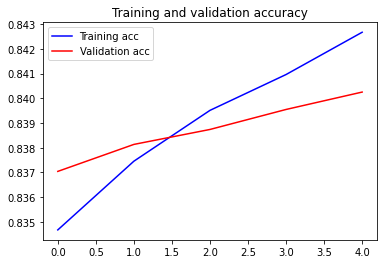

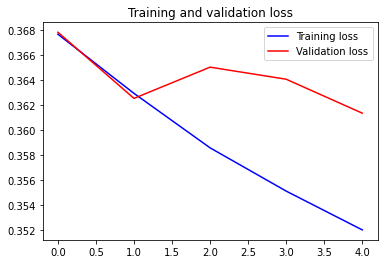

In [81]:
acc,  val_acc  = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [82]:
score = training_model.evaluate(X_test, y_test, batch_size=1024)
print("ACCURACY:",score[1])
print("LOSS:",score[0])

79/79 [==============================] - 7s 85ms/step - loss: 0.3608 - accuracy: 0.8386
ACCURACY: 0.8386374711990356
LOSS: 0.3608211874961853


In [83]:
# Predicting on the Test dataset.
y_pred = training_model.predict(X_test)

# Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>=0.5, 1, 0)

2500/2500 [==============================] - 22s 8ms/step


In [84]:
# Print the evaluation metrics for the dataset.
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84     39999
           1       0.83      0.85      0.84     40001

    accuracy                           0.84     80000
   macro avg       0.84      0.84      0.84     80000
weighted avg       0.84      0.84      0.84     80000



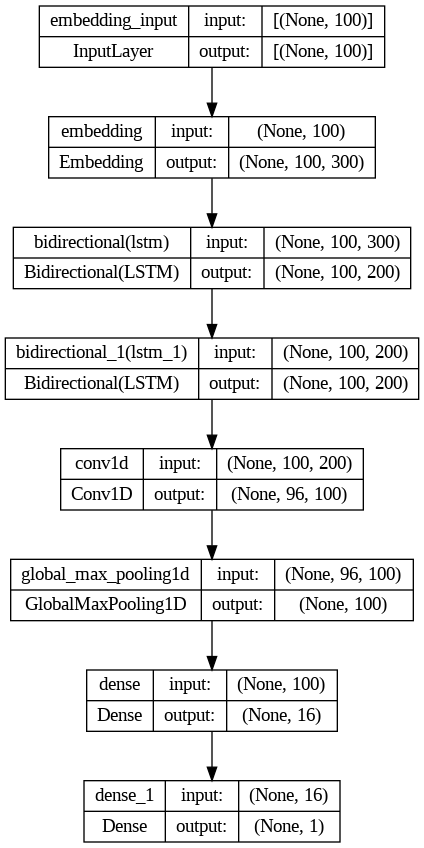

In [85]:
from keras.utils.vis_utils import plot_model

plot_model(training_model,to_file='lstm_model.png',show_layer_names=True, show_shapes=True)

In [87]:
import pickle
# Saving Word2Vec-Model
word2vec_model.wv.save('/content/drive/MyDrive/MLAI project/Word2Vec-twitter')
word2vec_model.wv.save_word2vec_format('/content/drive/MyDrive/MLAI project/Word2Vec-twitter-trainable')

# Saving the tokenizer
with open('Tokenizer.pickle', 'wb') as file:
    pickle.dump(tokenizer, file)

# Saving the TF-Model.
training_model.save('/content/drive/MyDrive/MLAI project/Sentiment-BiLSTM')
training_model.save_weights("/content/drive/MyDrive/MLAI project/Model Weights/weights")